In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import xgboost
from xgboost import XGBClassifier
import joblib
import seaborn as sns
import pickle
from importlib import reload
import csv

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables
import Utilities.Functions as Functions
from Utilities.ipython_exit import exit

print ('Success')

Welcome to JupyROOT 6.24/06
Success


## Reading in files

In [2]:
Params = {"Run":"run3", #The run number, so far either "run1" or "run3"
          "Load_single_file":False, #This will override everything else, put the desired file in the "single_file" line
          "single_file":245,
          "Load_standard":True, #bkgs
          "Load_lepton_signal":True,
          "Load_pi0_signal":False,
          "Load_DetVars":False, #This is for overlay
          "Only_keep_common_DetVar_evs":True,
          "Load_Signal_DetVars":False, #Don't do here, but in seperate script
          "Load_data":False,
          "FLATTEN":True, #Have one row per reconstructed object in the analysis dataframe
          "only_presel":False, #Create small files containing only variables necessary for pre-selection, for making pre-selection plots
          "EXT_in_training":False,
          "Use_logit":True,
          "nbins":5} 

feature_names = Variables.First_pass_vars_for_BDT #All variables
feature_names_MC = feature_names + ["weight"]
loc_pkls = "pkl_files/"+Params["Run"]+"/current_files/my_vars/"

samples = Functions.create_test_samples_list(Params)

if Params["Load_pi0_signal"] == True:
    pi0_sample_strings = [] #Unfortunately need to make, to discriminate lepton final states from pi0 final states for signal
    for pi0_point in Constants.HNL_mass_pi0_samples:
        pi0_sample_strings += [str(pi0_point)+"_pi0"]

Loading these run3 samples: 
['overlay', 'dirtoverlay', 'beamoff', 2, 10, 20, 50, 100, 150, 180, 200, 220, 240, 245]


In [3]:
sample_test_dict = {}
for sample in samples:
    if sample in Constants.Detector_variations: #Reading in an overlay DetVar sample
        loc=loc_pkls+"DetVars/"+"Preselected_overlay_"+Params["Run"]+"_my_vars"+f"_{sample}_flattened_reduced_evs.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    elif Params["Load_Signal_DetVars"] == True:
        loc=loc_pkls+"Signal_DetVars/"+"Preselected_"+Params["Run"]+f"_{sample}_reduced_evs_final.pkl"
        sample_test_dict[sample] = pd.read_pickle(loc)
    elif Params["Load_pi0_signal"] == True:
        if sample == 'overlay':
            # sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+"_FIXED.pkl")
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_overlay_"+Params["Run"]+".pkl")
        elif sample in pi0_sample_strings:
            # sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+"_FIXED.pkl")
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/pi0_selection/Test_signal_{sample}_"+Params["Run"]+".pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/pi0_selection/Test_beamoff_"+Params["Run"]+".pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"pi0_selection/Preselected_"+Params["Run"]+f"_{sample}.pkl")
    else: #Standard sample types
        if sample == 'overlay':
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_overlay_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
        elif (Params["Load_single_file"] == True) and (isinstance(sample,int)):
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
        elif sample in Constants.HNL_mass_samples:
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"BDT_Test_dfs/Test_signal_{sample}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
        elif (sample == 'beamoff') and (Params["EXT_in_training"] == True): #EXT only if extra EXT has been added
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+"BDT_Test_dfs/Test_beamoff_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")
        else: 
            sample_test_dict[sample] = pd.read_pickle(loc_pkls+f"Preselected_{sample}_"+Params["Run"]+"_my_vars_flattened_ultimate.pkl")


In [4]:
if Params["Run"] == "run1": BDT_name = "ultimate_full_reduced_benchmark"
if Params["Run"] == "run3": BDT_name = "ultimate_benchmark_plus_flashmatch"
if Params["Load_pi0_signal"] == True: BDT_name = "pi0_" + BDT_name

if Params["Load_pi0_signal"] == False:
    with open("bdts/input_vars/"+BDT_name, "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)
elif Params["Load_pi0_signal"] == True:
    with open("bdts/pi0_selection/input_vars/"+BDT_name, "rb") as fp:   # Unpickling
        saved_variables = pickle.load(fp)

bdt_vars = saved_variables
xgb_test_dict = {}

# BDT_name = "_New_20_variables_FIXED.json"
# BDT_name = "_ultimate.json"

for sample in sample_test_dict:
    xgb_test_dict[sample] = xgboost.DMatrix(sample_test_dict[sample][bdt_vars])
    # print("Done " + str(sample))
    
if Params["Load_single_file"] == True:
    HNL_mass = Params["single_file"]
    bdt = xgboost.Booster()
    bdt.load_model(f"bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
    for sample in xgb_test_dict:
        results = bdt.predict(xgb_test_dict[sample])
        sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
    
elif Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        bdt = xgboost.Booster()
        bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
        # bdt.load_model("bdts/"+Params["Run"]+f"_{HNL_mass}_MeV_{BDT_name}.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results
            
elif Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        bdt = xgboost.Booster()
        # bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}_MeV_pi0_FIXED.json")
        bdt.load_model(f"bdts/pi0_selection/"+Params["Run"]+f"_{HNL_mass}MeV_{BDT_name}.json")
        for sample in xgb_test_dict:
            results = bdt.predict(xgb_test_dict[sample])
            sample_test_dict[sample][f"BDT_output_{HNL_mass}MeV"] = results

print(len(bdt_vars))
print(bdt_vars)

19
['n_pfps', 'n_tracks', 'shr_theta_v', 'shr_phi_v', 'shr_pz_v', 'shrclusdir2', 'shr_energy_tot', 'trk_theta_v', 'trk_phi_v', 'trk_dir_z_v', 'trk_energy', 'trk_energy_tot', 'trk_calo_energy_u_v', 'trk_score_v', 'pfnplanehits_U', 'pfnplanehits_V', 'pfnplanehits_Y', 'NeutrinoEnergy2', 'nu_flashmatch_score']


## Checking max BDT score (for logit transformation)

In [5]:
if Params["Load_pi0_signal"] == False: HNL_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"] == True: HNL_masses = Constants.HNL_mass_pi0_samples
elif Params["Load_single_file"] == True: HNL_masses = [Params["single_file"]]

max_scores = []
for HNL_mass in HNL_masses:
    if Params["Load_pi0_signal"] == False:
        max_scores.append(max(Functions.logit(sample_test_dict[HNL_mass][f"BDT_output_{HNL_mass}MeV"])))
    if Params["Load_pi0_signal"] == True:
        max_scores.append(max(Functions.logit(sample_test_dict[str(HNL_mass)+"_pi0"][f"BDT_output_{HNL_mass}MeV"])))
    
max_all_scores = max(max_scores)
print("Maximum score for all signal samples is " + str(max_all_scores))

max_score_int = np.ceil(max_all_scores)
print("Maximum integer for bins is " + str(max_score_int))

Maximum score for all signal samples is 6.613988399505615
Maximum integer for bins is 7.0


In [ ]:
if Params["Load_Signal_DetVars"] == True: max_score_int = 7.0

## Merging bins with zero bkg prediction

In [6]:
#Checking which bins to merge Need to properly write this
merged_bins_dict = {}
min_score_cut = -5.0
xlims = [min_score_cut,max_score_int]
nbins = int(xlims[1]-xlims[0])
print("Initial nbins is " + str(nbins))
print("With range of " + str(xlims))

for HNL_mass in HNL_masses:
    bins_list = np.histogram(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV'],bins=nbins,range=xlims)[1]
    if Params["Use_logit"] == True:
        bkg_scores=[Functions.logit(sample_test_dict['overlay'][f'BDT_output_{HNL_mass}MeV']),
                    Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{HNL_mass}MeV']),
                    Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV'])]
    totbkg=np.histogram(bkg_scores[0],bins=nbins,range=xlims)[0]+np.histogram(bkg_scores[1],bins=nbins,range=xlims)[0]+np.histogram(bkg_scores[2],bins=nbins,range=xlims)[0]
    offbkg=np.histogram(bkg_scores[2],bins=nbins,range=xlims)[0]
    overlaybkg=np.histogram(bkg_scores[0],bins=nbins,range=xlims)[0]
    dirtbkg=np.histogram(bkg_scores[1],bins=nbins,range=xlims)[0]
    bins_new=[]
    for i,bin_bkg in enumerate(totbkg):
        if(overlaybkg[i]>1): #Checking if unweighted overlay bkg has at least one event in the bin
            bins_new.append(bins_list[i])

    bins_new.append(bins_list[-1])
    merged_bins_dict[HNL_mass] = bins_new
  

Initial nbins is 12
With range of [-5.0, 7.0]


## Plotting BDT outputs

In [7]:
#Needs to be rewritten, perhaps made into a function
train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)
    
if Params["Run"] == "run1":
    overlay_scale = Constants.SF_overlay_run1*SF_test
    EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run1
    dirt_scale = Constants.SF_dirt_run1
        
elif Params["Run"] == "run3":
    overlay_scale = Constants.SF_overlay_run3*SF_test
    EXT_scale_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{HNL_mass}MeV']))*Constants.SF_EXT_run3
    dirt_scale = Constants.SF_dirt_run3

print("Creating the sample and normalisation dictionaries")    
samples_plot={'overlay_test':sample_test_dict['overlay'],
         'dirtoverlay':sample_test_dict['dirtoverlay'],
         'beamoff':sample_test_dict['beamoff']}

sample_norms={'overlay_test':np.array(sample_test_dict['overlay']["weight"]*overlay_scale),
         'dirtoverlay':np.array(sample_test_dict['dirtoverlay']["weight"]*dirt_scale),
         'beamoff':EXT_scale_list}

print("Adding signal samples to sample plot dictionary")
if Params["Load_single_file"] == True:
    HNL_mass = Params["single_file"]
    signal_scale_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*SF_test
    samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
    sample_norms[HNL_mass]=signal_scale_list
    samples_plot["beamgood"]=sample_test_dict["beamgood"]
    sample_norms["beamgood"]=np.ones(len(sample_test_dict["beamgood"]))
elif Params["Load_pi0_signal"] == False:
    for HNL_mass in Constants.HNL_mass_samples:
        signal_scale_list = np.ones(len(sample_test_dict[HNL_mass][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[HNL_mass]=sample_test_dict[HNL_mass]
        sample_norms[HNL_mass]=signal_scale_list
if Params["Load_pi0_signal"] == True:
    for HNL_mass in Constants.HNL_mass_pi0_samples:
        signal_scale_list = np.ones(len(sample_test_dict[str(HNL_mass)+"_pi0"][f'BDT_output_{HNL_mass}MeV']))*SF_test
        samples_plot[HNL_mass]=sample_test_dict[str(HNL_mass)+"_pi0"]
        sample_norms[HNL_mass]=signal_scale_list

Creating the sample and normalisation dictionaries
Adding signal samples to sample plot dictionary


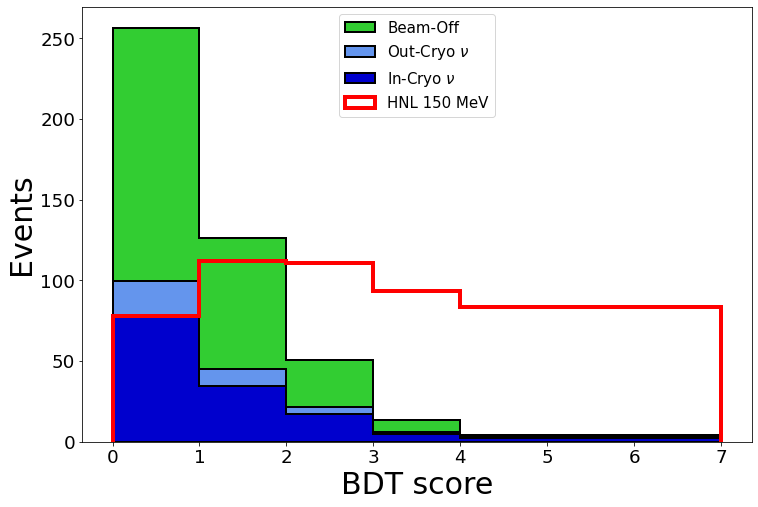

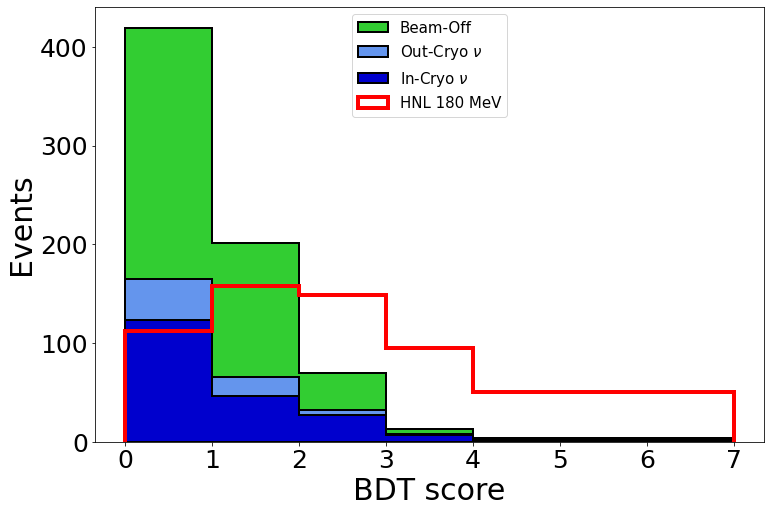

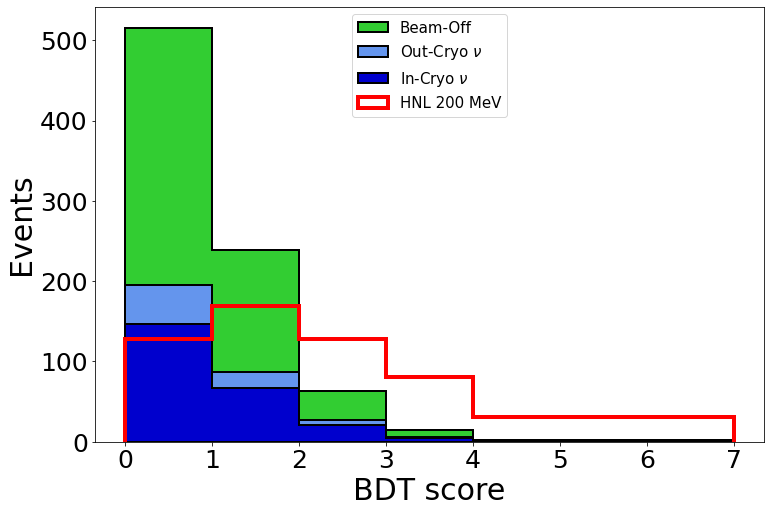

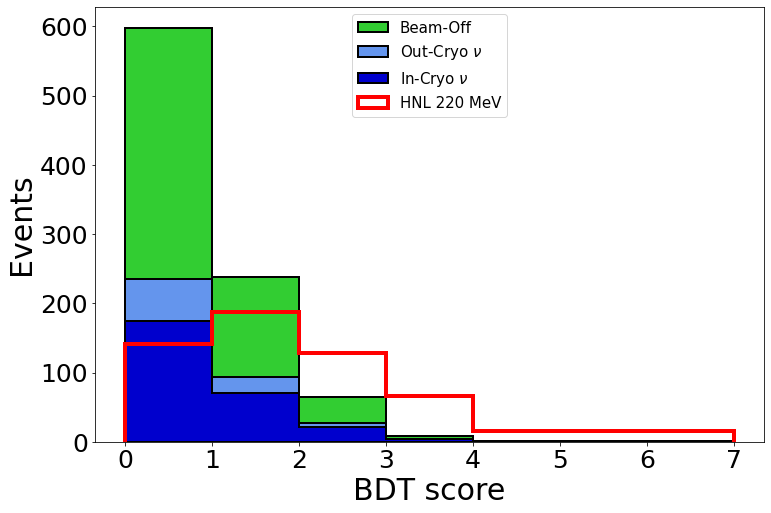

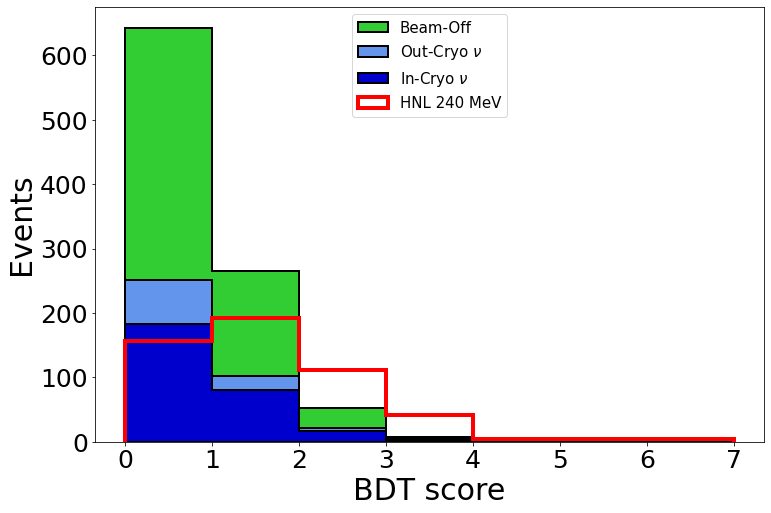

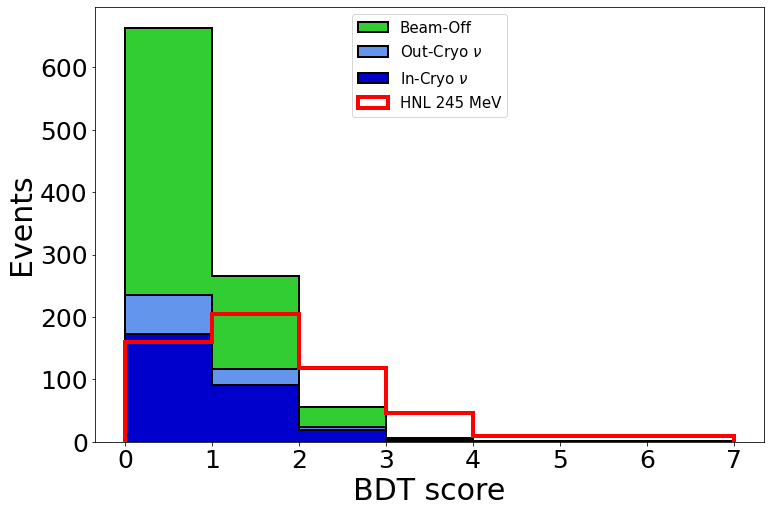

In [8]:
reload(PT)

if Params["Load_single_file"] == True:
    HNL_masses = [Params["single_file"]]
elif Params["Load_pi0_signal"] == False:
    HNL_masses = Constants.HNL_mass_samples
if Params["Load_pi0_signal"] == True:
    HNL_masses = Constants.HNL_mass_pi0_samples
    
xlims=[0,max_score_int]    
BINS = int(xlims[1]-xlims[0])
    
PT.Plot_BDT_output(HNL_masses=HNL_masses, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
                   bins=BINS,figsize=[12,8], MergeBins=True, density=False, legloc="upper center",logy=False, savefig=False, 
                   save_str = BDT_name, Run=Params["Run"], logit = Params["Use_logit"], HNL_scale=0.02)

#If plotting data too: Write this
# PT.Plot_BDT_output_data(HNL_masses=HNL_masses, samples=samples_plot, sample_norms=sample_norms, colours={}, xlims=xlims,
#                    bins=BINS,figsize=[12,8], MergeBins=True, density=False, legloc="best",logy=False, savefig=True, 
#                    save_str = BDT_name, Run=Params["Run"], logit = Params["Use_logit"], HNL_scale=0.02)

## Saving BDT output to .root files

In [9]:
def Save_one_hist(hist,name,nbins,xlims):
    tData = ROOT.TH1F(name,name,len(nbins)-1,array("d",nbins))
    for i in range(len(nbins)-1):
        tData.SetBinContent(i+1,hist['hist'][i])
        tData.SetBinError(i+1,hist['err'][i])
    return tData
    
def SaveToRoot_new(nbins,xlims,hist_samples,theta,fileName='test.root'): 
    rFile = ROOT.TFile(f'{fileName}','RECREATE')
    tData = ROOT.TH1F("theta","theta",1,array("d",[0,1]))
    tData.SetBinContent(1,theta)
    rFile.Write()
    for i, name in enumerate(hist_samples):
        tData = Save_one_hist(hist_samples[name],name,nbins,xlims)
        rFile.Write()
    rFile.Close()

def make_stat_err(hist, SF): #This doesn't take the weights into account, assumes they average to 1.0
    stat_err = []
    for i in range(0,len(hist[0])):
        error = np.sqrt(hist[0][i])*np.sqrt(SF)
        stat_err.append(error)
    return stat_err

def make_stat_err_true(var, bins, weights_times_SF): #Saved in Functions.py
    hist_unweighted = np.histogram(var,bins=bins)[0]
    hist_weighted = np.histogram(var,bins=bins,weights=weights_times_SF)[0]
    Total_SF = np.nan_to_num(hist_weighted/hist_unweighted)
    stat_err = np.sqrt(hist_unweighted)*Total_SF
    return stat_err

def make_stat_err_new(var, bins, weights_times_SF): 
    hist_squared = np.histogram(var,bins=bins,weights=weights_times_SF**2)[0]
    stat_err=np.sqrt(hist_squared)
    return stat_err

def SF_times_weights(sample_dict, sample, Run, SF_test, SF_signal):
    if Run == "run1": POT_norm = Constants.run1_POT_scaling_dict
    if Run == "run3": POT_norm = Constants.run3_POT_scaling_dict
    
    if sample == 'overlay': SF = sample_dict[sample]['weight']*POT_norm[sample]*SF_test
    elif sample == 'dirtoverlay': SF = sample_dict[sample]['weight']*POT_norm[sample]
    elif (sample == 'beamoff') or (sample =='beamgood'): SF = np.ones(len(sample_dict[sample][f'run']))*POT_norm[sample]
    else: 
        SF = np.ones(len(sample_dict[sample][f'BDT_output_{sample}MeV']))*(POT_norm[sample]*SF_test*SF_signal)
    return SF

def SF_times_weights_pi0(sample_dict, sample, Run, SF_test, SF_signal):
    if Run == "run1": POT_norm = Constants.run1_POT_scaling_dict
    if Run == "run3": POT_norm = Constants.run3_POT_scaling_dict
    
    if sample == 'overlay': SF = sample_dict[sample]['weight']*POT_norm[sample]*SF_test
    elif sample == 'dirtoverlay': SF = sample_dict[sample]['weight']*POT_norm[sample]
    elif (sample == 'beamoff') or (sample =='beamgood'): SF = np.ones(len(sample_dict[sample][f'run']))*POT_norm[sample]
    else: 
        SF = np.ones(len(sample_dict[str(sample)+"_pi0"][f'BDT_output_{sample}MeV']))*(POT_norm[str(sample)+"_pi0"]*SF_test*SF_signal)
    return SF

In [ ]:
SCALE_UP_dict = {2:5,10:5,20:200,50:50,100:10,150:5,180:4,200:4,220:4,240:4,245:4} #Doing this because the scale factor used in pyhf is bounded

new_theta_dict, dict_for_root = {}, {}

if Params["Load_pi0_signal"] == True: exit() #This cell is for lepton samples

bkg_samples = []
for sample in samples:
    if isinstance(sample,str): bkg_samples.append(sample)

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

print("Saving minimum BDT score of " + str(merged_bins_dict[245][0]))

for HNL_mass in HNL_masses:
    original_theta = Constants.theta_mu_4_dict[HNL_mass]
    new_theta = original_theta*SCALE_UP_dict[HNL_mass]
    new_theta_dict[HNL_mass] = original_theta*SCALE_UP_dict[HNL_mass]
    SCALE_EVENTS = SCALE_UP_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    
    bins = merged_bins_dict[HNL_mass]
    sample_list = bkg_samples + [HNL_mass]
    # if Params["Load_data"] == True: sample_list += ["beamgood"]
    for sample in sample_list:
        score = Functions.logit(sample_test_dict[sample][f'BDT_output_{HNL_mass}MeV'])
        SF_list = SF_times_weights(sample_test_dict, sample, Params["Run"], SF_test, SCALE_EVENTS)
        stat_err = make_stat_err_true(score, bins, SF_list)
        hist = np.histogram(score, bins=bins, weights=SF_list)
        dict_for_root[sample] = {'bins': np.array(hist[1]), 'hist': np.array(hist[0]), 'err': np.array(stat_err)}
        
    hist_samples = {"bkg_overlay":dict_for_root['overlay'],"bkg_dirt":dict_for_root['dirtoverlay'],
                    "bkg_EXT":dict_for_root['beamoff'],"signal":dict_for_root[HNL_mass]}
    if 'beamgood' in bkg_samples:
        hist_samples.update({"data":dict_for_root['beamgood']})
        
    save_name = Params["Run"]+f"_{HNL_mass}MeV_logit_ultimate_benchmark_data_test.root"
    
    SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="bdt_output/"+save_name)
    SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="Uncertainties/"+save_name)
print("Saved all")

## Saving pi0 sample

In [ ]:
Constants.run1_POT_scaling_dict.keys()

In [10]:
SCALE_UP_pi0_dict = {150:10.0, 180:5, 200:2, 220:2, 240:1.0, 245:1.0} 

new_theta_dict, dict_for_root = {}, {}

if Params["Load_pi0_signal"] == False: exit()

# bkg_samples = []
# for sample in samples:
#     if isinstance(sample,str): bkg_samples.append(sample)
bkg_samples = ['overlay', 'dirtoverlay', 'beamoff']
if Params["Load_data"] == True: bkg_samples = bkg_samples + ['beamgood']

train_vs_test_fraction = 0.7 #This was set in 3_BDT_training, need to change if I have changed this there.
SF_test = 1.0/(1-train_vs_test_fraction)

for HNL_mass in HNL_masses:
    original_theta = 1e-4 #Same for all samples
    new_theta = original_theta*SCALE_UP_pi0_dict[HNL_mass]
    new_theta_dict[HNL_mass] = original_theta*SCALE_UP_pi0_dict[HNL_mass]
    SCALE_EVENTS = SCALE_UP_pi0_dict[HNL_mass]**4 #The Number of events is proportional to theta^4
    
    bins = merged_bins_dict[HNL_mass]
    sample_list = bkg_samples + [HNL_mass]
    # if Params["Load_data"] == True: sample_list += ["beamgood"]
    print(sample_list)
    for sample in sample_list:
        sample_test = sample
        if isinstance(sample,int): sample_test = str(sample) + "_pi0"
        score = Functions.logit(sample_test_dict[sample_test][f'BDT_output_{HNL_mass}MeV'])
        SF_list = SF_times_weights_pi0(sample_test_dict, sample, Params["Run"], SF_test, SCALE_EVENTS)
        stat_err = make_stat_err_true(score, bins, SF_list)
        hist = np.histogram(score, bins=bins, weights=SF_list)
        dict_for_root[sample] = {'bins': np.array(hist[1]), 'hist': np.array(hist[0]), 'err': np.array(stat_err)}
        
    hist_samples = {"bkg_overlay":dict_for_root['overlay'],"bkg_dirt":dict_for_root['dirtoverlay'],
                    "bkg_EXT":dict_for_root['beamoff'],"signal":dict_for_root[HNL_mass]}
    if 'beamgood' in bkg_samples:
        hist_samples.update({"data":dict_for_root['beamgood']})
        
    save_name = Params["Run"]+f"_{HNL_mass}MeV_logit_ultimate_benchmark_test.root"
    
    SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="bdt_output/pi0/"+save_name)
    SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName="Uncertainties/pi0/"+save_name)
print("Saved all")

['overlay', 'dirtoverlay', 'beamoff', 150]
['overlay', 'dirtoverlay', 'beamoff', 180]
['overlay', 'dirtoverlay', 'beamoff', 200]
['overlay', 'dirtoverlay', 'beamoff', 220]
['overlay', 'dirtoverlay', 'beamoff', 240]
['overlay', 'dirtoverlay', 'beamoff', 245]


/home/david/jupyter/envs/ana/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


Saved all


## Calculating efficiency

In [ ]:
def calculate_efficiency(df, file_name, Run, BDT_cutoff, HNL_mass, debug=False):
    if Run == "run1": ev_num_dict = Constants.run1_event_numbers
    if Run == "run3": ev_num_dict = Constants.run3_event_numbers
    
    if file_name == "beamoff" or file_name == "dirtoverlay":
        norm = 1.0
    else:
        train_vs_test_fraction = 0.7 #Set in script 3.0
        norm = 1.0/(1-train_vs_test_fraction) #Need to scale up to account for events lost
    
    total_ev_num = len(df)
    ev_num_initial = ev_num_dict[file_name]
    cut_df = df.query(f"BDT_output_{HNL_mass}MeV > {BDT_cutoff}")
    new_ev_num = len(cut_df)
    
    efficiency = norm*(new_ev_num/ev_num_initial)
    
    if debug:
        print(f"Total events is {total_ev_num}")
        print(f"Events after cut is {new_ev_num}")
    
    return efficiency

def sum_total_weights(df): #This is to check that the weighting doesn't affect the overall efficiency significantly (i.e av weight is approx 1)
    total_evs = len(df)
    sum_weights = df["weight"].sum()
    
    weight_per_ev = sum_weights/total_evs
    
    print(f"Sum of weights is {sum_weights}")
    print(f"Average weight is {weight_per_ev}")

In [ ]:
print(sample_test_dict.keys())

In [ ]:
logit_BDT_cut = -20
# logit_BDT_cut = 2.0
standard_BDT_cut = Functions.invlogit(logit_BDT_cut)
print(f"Using a logit BDT cut of {logit_BDT_cut}, which corresponds to {standard_BDT_cut} in [0,1] BDT score.")

efficiency_dict = {}

for file in Constants.HNL_mass_samples: #Just signal samples
# for file in sample_test_dict:

    efficiency_dict[file] = calculate_efficiency(sample_test_dict[file], file, Params["Run"], standard_BDT_cut, file, debug=False)


In [ ]:
for file in ['overlay', 'dirtoverlay', 'beamoff']: #Calculating efficiency for 100MeV BDT model score

    efficiency_dict[file] = calculate_efficiency(sample_test_dict[file], file, Params["Run"], standard_BDT_cut, 100, debug=True)

In [ ]:
print(Params["Run"] + " pre-selectoin efficiencies are")
for file in sample_test_dict:
    # print(f"{file} efficiency is " + str(efficiency_dict[file]))
    print(f"{file} efficiency is " + str(efficiency_dict[file]*100) + " %")

## "Closure test" i.e testing adjacent 

In [ ]:
# mass_point = 50
mass_point = 245

savefig = False

test_models = [150, 180]

test_results, test_labels = [], []

plt.figure(figsize=[12,8],facecolor='white')

for mass_model in test_models:
    test_results.append(Functions.logit(samples_plot[mass_point][f'BDT_output_{mass_model}MeV']))
    test_labels.append(f"{mass_model} MeV model")

plot=plt.hist(Functions.logit(samples_plot[mass_point][f'BDT_output_{mass_point}MeV']),label=f"Correct {mass_point} MeV model",
                         range=xlims,bins=merged_bins_dict[mass_point],histtype="step",
                         stacked=False,density=False,linewidth=4)
plot=plt.hist(test_results,label=test_labels,range=xlims,bins=merged_bins_dict[mass_point],histtype="step",
              stacked=False,density=False,linewidth=2)

plt.xlabel(f"BDT score for {mass_point} MeV sample")
plt.ylabel("Events")
plt.legend(loc="upper left")
if savefig == True:
    plt.savefig("plots/BDT_output/Adjacent_models_tests/" + Params["Run"] + "_" + str(mass_point) + "MeV_adjcent_models.pdf")
    plt.savefig("plots/BDT_output/Adjacent_models_tests/" + Params["Run"] + "_" + str(mass_point) + "MeV_adjcent_models.png")
plt.show()

In [ ]:
#Saving the output in a .root file
bkg_list = ['overlay', 'dirtoverlay', 'beamoff']
new_theta = original_theta*SCALE_UP_dict[mass_point]
bkg_hist_dict = {}
# test_models += [mass_point]
# res = [*set(test_models)]
# print(res)
# print(test_models)
for mass_model in test_models+[mass_point]:
    # for bkg in bkg_list:
    #     bkg_hist_dict[bkg] = Functions.logit(sample_test_dict[bkg][f'BDT_output_{mass_model}MeV'])
    SF_signal_list = np.ones(len(sample_test_dict[mass_point][f'BDT_output_{mass_model}MeV']))*Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS
    SF_overlay_list = sample_test_dict['overlay']['weight']*Constants.SF_overlay_run1*SF_test
    SF_dirt_list = sample_test_dict['dirtoverlay']['weight']*Constants.SF_dirt_run1
    SF_EXT_list = np.ones(len(sample_test_dict['beamoff'][f'BDT_output_{mass_model}MeV']))*Constants.SF_EXT_run1
    
    bins=merged_bins_dict[mass_point]
    signal_bdt_hist = np.histogram(Functions.logit(sample_test_dict[mass_point][f'BDT_output_{mass_model}MeV']), 
                               bins=bins, weights=SF_signal_list, range = xlims_logit)
    overlay_bdt_hist = np.histogram(Functions.logit(sample_test_dict['overlay'][f'BDT_output_{mass_model}MeV']), 
                                bins=bins, weights=SF_overlay_list, range = xlims_logit)
    dirt_bdt_hist = np.histogram(Functions.logit(sample_test_dict['dirtoverlay'][f'BDT_output_{mass_model}MeV']), 
                             bins=bins, weights=SF_dirt_list, range = xlims_logit)
    EXT_bdt_hist = np.histogram(Functions.logit(sample_test_dict['beamoff'][f'BDT_output_{mass_model}MeV']), 
                            bins=bins, weights=SF_EXT_list, range = xlims_logit)

    signal_bdt_err = make_stat_err(signal_bdt_hist, Constants.run1_POT_scaling_dict[HNL_mass]*SF_test*SCALE_EVENTS)
    overlay_bdt_err = make_stat_err(overlay_bdt_hist, Constants.SF_overlay_run1*SF_test)
    dirt_bdt_err = make_stat_err(dirt_bdt_hist, Constants.SF_dirt_run1)
    EXT_bdt_err = make_stat_err(EXT_bdt_hist, Constants.SF_EXT_run1)

    data_h = overlay_bdt_hist[0]+dirt_bdt_hist[0]+EXT_bdt_hist[0]

    bkg_overlay = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(overlay_bdt_hist[0]), 'err': np.array(overlay_bdt_err)}
    bkg_dirt = {'bins': np.array(dirt_bdt_hist[1]), 'hist': np.array(dirt_bdt_hist[0]), 'err': np.array(dirt_bdt_err)}
    bkg_EXT = {'bins': np.array(EXT_bdt_hist[1]), 'hist': np.array(EXT_bdt_hist[0]), 'err': np.array(EXT_bdt_err)}
    sig = {'bins': np.array(signal_bdt_hist[1]), 'hist': np.array(signal_bdt_hist[0]), 'err': np.array(signal_bdt_err)}
    data = {'bins': np.array(overlay_bdt_hist[1]), 'hist': np.array(data_h), 'err': np.array(overlay_bdt_err)}

    hist_samples = {"bkg_overlay":bkg_overlay,"bkg_dirt":bkg_dirt,"bkg_EXT":bkg_EXT,"signal":sig,"data":data}

    save_name = f"bdt_output/adjacent_models/"+ Params["Run"] + f"_{mass_point}MeV_{mass_model}MeV_model.root"
    SaveToRoot_new(merged_bins_dict[HNL_mass],xlims,hist_samples,theta=new_theta,fileName=save_name)
    print("Saved " + save_name)

## Saving BDT output for reweighting systematics plots

In [ ]:
pkl_results_loc = "pkl_files/"+Params["Run"]+"/current_files/Results/"

# print(sample_test_dict['overlay'].keys())

print_vals = input("Do you want to save the new BDT scores to .pkl files? y/n ")
if print_vals == "y":
    
    columns = Variables.event_vars + Variables.weight_related + ["weight"]
    for HNL_mass in Constants.HNL_mass_samples:
        columns.append(f'BDT_output_{HNL_mass}MeV')
    print(columns)
    
    overlay_to_save = sample_test_dict['overlay'][columns].copy()
    #df2 = overlay_merged_to_save.loc[:,~overlay_merged_to_save.columns.duplicated()] #Getting rid of duplicate "weight" column
    #df2.to_pickle(pkl_results_loc + "overlay_results.pkl")
    overlay_to_save.to_pickle(pkl_results_loc + "overlay_results_ultimate_r3_flashmatch.pkl")
    
    print(overlay_to_save.keys())

## Saving only high BDT Score events for variable study

In [ ]:
cutoff = 0.95
signal_like = {}
frac_retained = {}
pkl_variable_tests_loc = "pkl_files/"+Params["Run"]+"/current_files/Variable_tests/"

Number_signal = 1000
top_signal = {}

for HNL_mass in Constants.HNL_mass_samples:
    signal_like[HNL_mass] = sample_test_dict[HNL_mass].query(f"BDT_output_{HNL_mass}MeV > {cutoff}")
    frac_retained[HNL_mass] = len(signal_like[HNL_mass])/len(sample_test_dict[HNL_mass])
    
    signal_like[HNL_mass].to_pickle(pkl_variable_tests_loc + f"signal_like_{HNL_mass}_MeV.pkl")
    
    top_signal[HNL_mass] = sample_test_dict[HNL_mass].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(Number_signal)
    
print(frac_retained)


## Looking at variables for signal-like events vs. full sample

In [ ]:
plt.figure(figsize=[12,8],facecolor='white')

HNL_mass = 2

variable = 'contained_sps_ratio'

bins = 40
xlims = [0,1.0]

plt.hist(sample_test_dict[HNL_mass][variable],
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
         label=[f"All preselected {HNL_mass} MeV HNL"],
         range=xlims,bins=bins,
         stacked=False,density=True,
         histtype="step",lw=3)

plt.hist(top_signal[HNL_mass][variable],
#               label=[f"HNL ({mass} MeV) \n $|U_{{\mu4}}|^2="+sci_notation(sample_info["300"]["theta_u2"]) +f" (x{HNLplotscale})"],
         label=[f"Signal-like {HNL_mass} MeV HNL"],
         range=xlims,bins=bins,
         stacked=False,density=True,
         histtype="step",lw=3)
plt.xlabel(variable)
plt.legend()

## Make list of run subrun event which are most signal-like

In [ ]:
sample_CV_100 = sample_test_dict['100_CV']

In [ ]:
top_N = 50
csv_location = "bdt_output/signal_like_rse_lists/CV_samples/"
HNL_mass = 100
# for HNL_mass in Constants.HNL_mass_samples:
signal_sorted = sample_CV_100.sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
signal_run_sub_event = signal_sorted[["run", "sub", "evt"]]
csv_name = csv_location + Params["Run"] + f"_signal_CV_{HNL_mass}.csv"
signal_run_sub_event.to_csv(csv_name, sep=" ", header=False, index=False)

txt_file = csv_location + Params["Run"] + f"_signal_CV_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
with open(txt_file, "w") as my_output_file:
    with open(csv_name, "r") as my_input_file:
        [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
    my_output_file.close()

In [ ]:
top_N = 50
csv_location = "bdt_output/signal_like_rse_lists/"
for HNL_mass in Constants.HNL_mass_samples:
    signal_sorted = sample_test_dict[HNL_mass].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    overlay_sorted = sample_test_dict['overlay'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    dirt_sorted = sample_test_dict['dirtoverlay'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    beamoff_sorted = sample_test_dict['beamoff'].sort_values(f"BDT_output_{HNL_mass}MeV", ascending=False).head(top_N)
    signal_run_sub_event = signal_sorted[["run", "sub", "evt"]]
    overlay_run_sub_event = overlay_sorted[["run", "sub", "evt"]]
    dirt_run_sub_event = dirt_sorted[["run", "sub", "evt"]]
    beamoff_run_sub_event = beamoff_sorted[["run", "sub", "evt"]]
    # print(df_run_sub_event.keys())
    csv_name = csv_location + Params["Run"] + f"_signal_{HNL_mass}.csv"
    csv_overlay_name = csv_location + Params["Run"] + f"_overlay_{HNL_mass}.csv"
    csv_dirt_name = csv_location + Params["Run"] + f"_dirtoverlay_{HNL_mass}.csv"
    csv_beamoff_name = csv_location + Params["Run"] + f"_beamoff_{HNL_mass}.csv"

    signal_run_sub_event.to_csv(csv_name, sep=" ", header=False, index=False) #i.e separating by a space, removing column names
    overlay_run_sub_event.to_csv(csv_overlay_name, sep=" ", header=False, index=False)
    dirt_run_sub_event.to_csv(csv_dirt_name, sep=" ", header=False, index=False)
    beamoff_run_sub_event.to_csv(csv_beamoff_name, sep=" ", header=False, index=False)
    
    #signal
    csv_file = csv_name
    txt_file = csv_location + Params["Run"] + f"_signal_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #overlay
    csv_file = csv_overlay_name
    txt_file = csv_location + Params["Run"] + f"_overlay_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #dirt
    csv_file = csv_dirt_name
    txt_file = csv_location + Params["Run"] + f"_dirtoverlay_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()
        
    #beamoff
    csv_file = csv_beamoff_name
    txt_file = csv_location + Params["Run"] + f"_beamoff_{HNL_mass}.list" #could save this as .txt, just following Owen's naming system so using .list
    with open(txt_file, "w") as my_output_file:
        with open(csv_file, "r") as my_input_file:
            [ my_output_file.write(" ".join(row)+'\n') for row in csv.reader(my_input_file)]
        my_output_file.close()

# End of code